### 1. Executive Summary

Our project focuses on refining ICU patient monitoring systems by developing a specialized,
real-time machine learning model. This model will be designed to analyze a range of clinical
indicators specifically for sepsis patients, predicting when their conditions might escalate into
life-threatening situations.
The alarm system in our model will be highly targeted: it will only activate in cases of imminent,
critical danger to sepsis patients, avoiding the issuance of alerts for less severe conditions. This
focused approach aims to prevent the overload of false alarms, thereby reducing unnecessary
stress on ICU staff and ensuring that medical attention is directed swiftly and accurately to
patients in urgent need.
By ensuring that alarms are only triggered by truly critical situations, the model will enhance the
effectiveness of patient monitoring in the ICU, leading to better patient outcomes, fewer medical
errors, and improved overall efficiency in patient care management.

### 2. Data Description and Preprocessing


### 3. Feature & Model Selection --- RFE and Nested CV
To evaluate model performance and identify the most important features, we first separate 20% of the dataset as a real test set. The remaining data is used for nested cross-validation, employing stratified 5-fold cross-validation for both the outer and inner loops.

**Outer Cross-Validation: Model Selection**

For model selection, we evaluate logistic regression, random forest, and XGBoost using their default hyperparameters. Within each outer-loop training set, these models are passed to the inner loop for feature selection.

**Inner Cross-Validation: Feature Selection**

Within the inner loop, based on the outer-loop training folds, we perform stratified 5-fold cross-validation to identify the most important features. To automate feature selection, we use Recursive Feature Elimination (RFE). Specifically, the RFECV function is used to integrate feature selection and cross-validation seamlessly. When using XGBoost, we also incorporate a class weight hyperparameter based on the ratio of positive to negative classes. For each outer loop fold, the model will have a set of selected features from RFE. After completing the 5 folds in the outer loop for each model, we finalize the features that are selected more than half the time (i.e., selected in more than 2 out of the 5 folds) as the final set of features.
The selected features from the inner loop are then passed back to the outer loop to evaluate model performance.

**Results**

After completing nested cross-validation, we calculated the average model accuracy and identified the selected features for each model. To further analyze the impact of feature selection, we conducted additional experiments on datasets both with and without the inclusion of the "comorbidity" feature. While XGBoost did not achieve the highest performance among the three models, it selected fewer features, which reduced the feature dimensionality for the dataset without the "comorbidity" feature. This reduction in dimensionality can improve model inference speed.

Given these advantages, we chose to implement a stacked XGBoost model for prediction, as discussed in the next section.

'F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill_withComro.csv'

To avoid randomness of the results caused by train_test_split, we use stratified 5-fold cross-validation to evaluate this model. The average recall for mortality is 0.65, and for survival is 0.93.

#### 4.2 Stacked XGB Model
Then we use ensemble learning to try to improve the performance of the model. We utilized a linear regression to incorporate the output of three XGB models. To train this model, we firstly divide the training set into three sub dataset. Because the ratio of surviving patients to dead patients is approximately 3:1, each sub-training set is composed by combining 1/3 of the instances of surviving patients (non-repetitive sampling) with all instances of dead patients. To ensure a fair training environment for the three models, we maintain the same number of instances for prediction across all models. Therefore, despite using non-repetitive sampling for dividing the data of surviving patients as mentioned above, a very small number of patients are reused in practice to ensure that the number of instances in the dataset for training each XGBoost model is the same. Next, after predicting with the three XGBoost models on the complete training set, we will obtain three sets of predictions. These predictions will then be used as inputs for a linear regression model to fit the target value. This is the whole training process.
The prediction process for the stacked XGBoost models is as follows: The test data first passes through the three trained XGBoost models, and the outputs are then fed into a trained linear regression model to obtain the final predicted values. Since the output from the linear regression is a continuous value, we use 0.5 as a threshold to classify the predictions into two categories. Values less than 0.5 indicate survival, while values greater than 0.5 indicate death.

We use stratified cross-validation (CV) to validate the performance of the model. The results show that the stacked XGBoost model increases the recall of deceased patients by 6%, while it does not significantly affect the precision for surviving patients.
Therefore, we belived that XGB works the best.

#### 4.3 One class SVM 
Given that the dataset is imbalanced, we can adopt an alternative approach by using anomaly detection to predict patient mortality. One-class SVM is an excellent model for anomaly detection. This model uses unsupervised learning to capture the characteristics of the negative class (the majority class). It then determines whether new instances conform to the features of the majority class. Instances that do not fit are considered anomalies.

We applied the One-Class SVM (OCSVM) to our dataset and found that OCSVM tends to predict patients as dead. For the hyperparameters of the One-Class SVM (OCSVM), we use the RBF kernel because it is commonly used to handle nonlinear problems. The hyperparameter `nu` is set to 0.25, indicating that approximately 25% of the data is considered as anomalies. The `gamma` parameter is set to 0.7, determined through a suboptimal method of repeated trials rather than cross-validation. However, the stacked XGBoost model performs better in accurately predicting surviving patients. Therefore, we decided to integrate stacked XGBoost with OCSVM once again for ensemble learning. Additionally, we discovered that by obtaining the distance of each data point from the SVM hyperplane, standardizing these distances (to avoid extreme values affecting the distribution), and then normalizing them (converting distances to a range of 0-1), these distances can be interpreted as probabilities of being identified as anomalies. According to the default decision boundary of OCSVM, after transformation, the classification threshold should be 0.5 (greater than 0.5 for survival, less than 0.5 for death). However, after several trials, we found that 0.45 is a more suitable threshold. Although we have not delved deeper into this issue due to time constraints, and this thresholding method has not yet been applied in subsequent ensemble learning models, it merits further research.

#### 4.4 Stack XGB + OCSVM

We further refined our model by fitting the outputs of the stacked XGBoost linear regression with the distances of data points from the decision boundary obtained via OCSVM (which were standardized and normalized) using another linear regression to generate final predictions. Despite this innovative approach, applying the stacked XGBoost + OCSVM model on the complete dataset did not result in significant performance improvements.

#### 4.5 flashback to rfe feature selection
To identify the most effective features according to the One-Class SVM (OCSVM), we employed cross-validation again. However, because OCSVM uses a non-linear RBF kernel, it does not provide coefficient values for each feature. To address this challenge, we adopted a suboptimal method: we applied OCSVM to the feature sets previously selected by random forest, logistic regression, and XGBoost individually. We then evaluated the average accuracy of OCSVM on these feature sets and selected the set with the highest accuracy as the features deemed most important by OCSVM. The results indicate that the OCSVM selected the features chosen by logistic regression.
It is worth noting that none of the models selected the comorbidity feature. There are two possible explanations for this. The first is that, although sepsis is often caused by other illnesses, having multiple diseases does not significantly impact a patient's survival rate. The second explanation is that the dataset does not clearly indicate the diseases causing sepsis in patients; we can only infer a patient's comorbidities from hospital admission records. However, ultimately, out of nearly a thousand individuals, only slightly more than a hundred were considered to have comorbidities. This clearly indicates suboptimal results. Perhaps further exploration of the dataset is needed.

#### 4.6 Change stack models
We attempted to switch the stacking model, replacing the stacked XGBoost with stacked Random Forest (excluding OCSVM), but there was no significant difference in model performance. We then changed the stacking model again to include Random Forest, XGBoost, and Logistic Regression (without OCSVM). This change significantly improved the model's performance in predicting deceased patients (by +8%), but the performance in predicting surviving patients continued to decline (by -10%).

Subsequently, we added OCSVM to the stacked RF + Logistic Regression + XGBoost model, which again improved the model's performance, reaching a level similar to the original stacked XGBoost + OCSVM model.

#### 4.7 Consider selected feature
We incorporated features selected by Recursive Feature Elimination (RFE) for each model into the training process. While the performance of the stacked XGBoost + OCSVM model showed no significant change, the stacked Random Forest/Logistic Regression/XGBoost + OCSVM model experienced a remarkable improvement in accuracy. The classification recall for both surviving and deceased patients reached 95%. Although we are pleasantly surprised by this outcome, we have yet to find a satisfactory explanation for these results.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Flatten, Input
from sklearn.utils.class_weight import compute_class_weight

One class svm

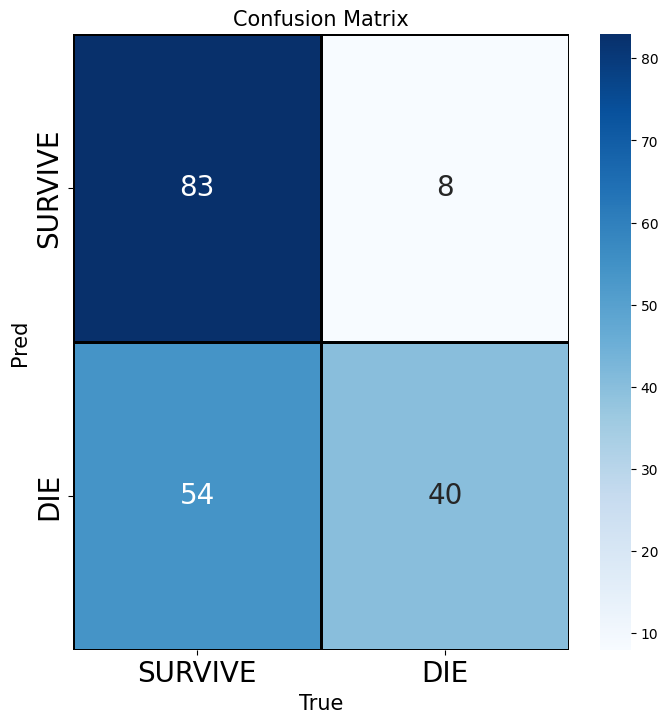

              precision    recall  f1-score   support

     SURVIVE       0.91      0.61      0.73       137
         DIE       0.43      0.83      0.56        48

    accuracy                           0.66       185
   macro avg       0.67      0.72      0.65       185
weighted avg       0.79      0.66      0.69       185

0.525810498011676


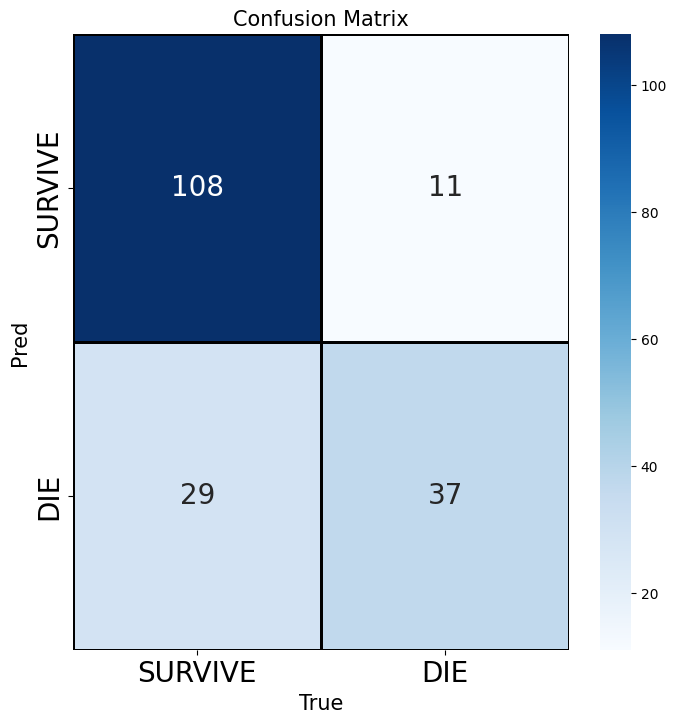

              precision    recall  f1-score   support

     SURVIVE       0.91      0.79      0.84       137
         DIE       0.56      0.77      0.65        48

    accuracy                           0.78       185
   macro avg       0.73      0.78      0.75       185
weighted avg       0.82      0.78      0.79       185



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv'

data = pd.read_csv(path)
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')


columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag']
X = data.drop(columns=columns_to_drop)
y = data['died_immediately']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

X_0 = x_train_scaled[y_train == 0].drop(columns=['died_immediately'])
X_1 = x_test_scaled[y_test == 1].drop(columns=['died_immediately'])
clf = OneClassSVM(nu=0.25, kernel="rbf", gamma=0.7)
clf.fit(X_0)


y_pred = clf.predict(x_test_scaled.drop(columns=['died_immediately']))
y_pred = np.where(y_pred == 1, 0, 1)  

labels = ['SURVIVE', 'DIE']
CM = confusion_matrix(y_test, y_pred)
CM = pd.DataFrame(CM, index=labels, columns=labels)

plt.figure(figsize=(8, 8))
sns.heatmap(CM.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('True', fontsize=15)
plt.ylabel('Pred', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))


### 很重要！！！！！！！！
### 先standardize，同比例缩放，降低有很异常的值影响。然后normalize，缩放到0-1，对应二分类的概率。
svm_scores = clf.decision_function(x_test_scaled.drop(columns=['died_immediately']))
mean_val = svm_scores.mean()
std_val = svm_scores.std()
standardized_scores = (svm_scores - mean_val) / std_val
min_val = standardized_scores.min()
max_val = standardized_scores.max()
normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

#存疑，理论的thresh不够好

thresh_norm = (0 - min_val) / (max_val - min_val)
print(thresh_norm)

y_pred = np.where(normalized_scores > 0.45, 0,1)


labels = ['SURVIVE', 'DIE']
CM = confusion_matrix(y_test, y_pred)
CM = pd.DataFrame(CM, index=labels, columns=labels)

plt.figure(figsize=(8, 8))
sns.heatmap(CM.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('True', fontsize=15)
plt.ylabel('Pred', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))



XGBoost

[0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0]


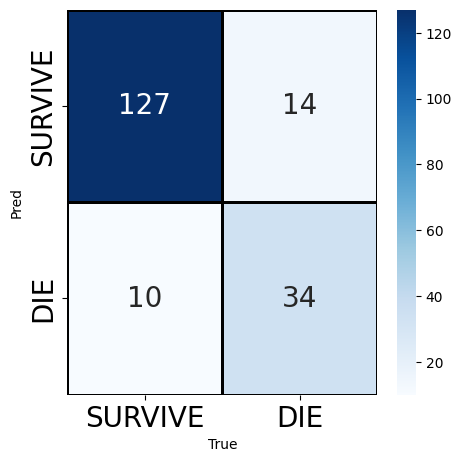

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       137
           1       0.77      0.71      0.74        48

    accuracy                           0.87       185
   macro avg       0.84      0.82      0.83       185
weighted avg       0.87      0.87      0.87       185



In [3]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv'
data = pd.read_csv(path)
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')


columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag','died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['icu_times', 'icu_times_total', 'hear_last_Asystole', 'hear_last_Normal Sinus', 'hear_last_Other/Remarks']]
#X = X[['bun_min', 'bun_avg', 'car_avg', 'pla_avg', 'hea_min', 'hea_max', 'hea_avg', 'spo_min', 'spo_avg', 'spo_alarms']]
#X = X[['icu_duration_hour', 'figglu_min', 'pot_avg', 'hem_avg', 'bun_min', 'bun_max', 'bun_avg', 'car_avg', 'pla_min', 
#       'pla_avg', 'wbc_min', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'res_min', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms']]
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = data['died_immediately']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(y_pred)
print(y_test.to_numpy())
labels = ['SURVIVE','DIE']
CM = confusion_matrix(y_test,y_pred)
CM = pd.DataFrame(CM, index = labels, columns = labels)
plt.figure(figsize = (5,5))
sns.heatmap(CM.T,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels,annot_kws={"fontsize":20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

print(classification_report(y_test, y_pred))

Startified K Fold for single XGBoost

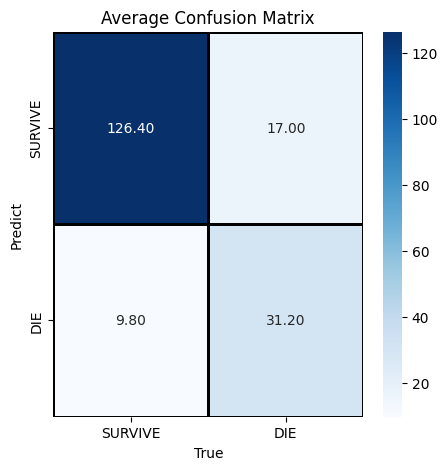

Class SURVIVE - Precision: 0.88, Recall: 0.93, F1 Score: 0.90, Support: 136.20000000000002
Class DEATH   - Precision: 0.76, Recall: 0.65, F1 Score: 0.70, Support: 48.2
Overall Accuracy: 0.8547


In [4]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv'
path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv'

data = pd.read_csv(path)

columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag','died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['icu_times', 'icu_times_total', 'hear_last_Asystole', 'hear_last_Normal Sinus', 'hear_last_Other/Remarks']]
#X = X[['bun_min', 'bun_avg', 'car_avg', 'pla_avg', 'hea_min', 'hea_max', 'hea_avg', 'spo_min', 'spo_avg', 'spo_alarms']]
#X = X[['bun_min', 'bun_max', 'car_avg', 'pla_min', 'hea_min', 'hea_max', 'hea_avg', 'spo_min', 'spo_max', 'spo_alarms']]
#X = X[['icu_duration_hour', 'figglu_min', 'pot_avg', 'hem_avg', 'bun_min', 'bun_max', 'bun_avg', 'car_avg', 'pla_min', 
#       'pla_avg', 'wbc_min', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'res_min', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms']]
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X = pd.DataFrame(X_scale, columns=X.columns, index=X.index)


y = data['died_immediately']

skf = StratifiedKFold(n_splits=5, random_state=64, shuffle=True)

confusion_matrices = []

for train_index, test_index in skf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

mean_cm = np.mean(confusion_matrices, axis=0)

mean_cm_df = pd.DataFrame(mean_cm, index=['SURVIVE', 'DIE'], columns=['SURVIVE', 'DIE'])

plt.figure(figsize=(5, 5))
sns.heatmap(mean_cm_df.T, cmap="Blues", annot=True, fmt=".2f", linecolor='black', linewidth=1, 
            xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Average Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predict')
plt.show()

TN, FP, FN, TP = mean_cm[0, 0], mean_cm[0, 1], mean_cm[1, 0], mean_cm[1, 1]

precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0

recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

accuracy = (TP + TN) / (TP + TN + FP + FN)

support_0 = TN + FP
support_1 = TP + FN

print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
print(f"Overall Accuracy: {accuracy:.4f}")

Stacking xgboost

Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567

[[374   0]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8432432432432433
Confusion Matrix:
 [[124  13]
 [ 16  32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       137
           1       0.71      0.67      0.69        48

    accuracy                           0.84       185
   macro avg       0.80      0.79      0.79       185
weighted avg       0.84      0.84      0.84       185

norm
Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       192

    accuracy 

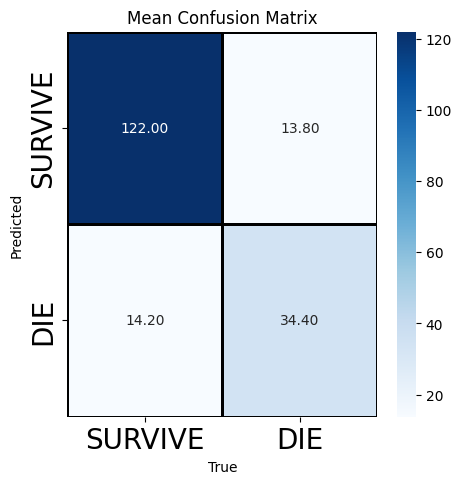

Class SURVIVE - Precision: 0.90, Recall: 0.90, F1 Score: 0.90, Support: 136.2
Class DEATH   - Precision: 0.71, Recall: 0.71, F1 Score: 0.71, Support: 48.2
Overall Accuracy: 0.8482


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

def train_stackXGB(X_train, y_train, thresh = 0.5, norm = False):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos

        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_fold)

    final_pred = lin_reg.predict(predictions)
    final_pred = (final_pred > 0.5).astype(int) 
    
    
    
    ########## normalize scores
    #if norm :
    #    print('niorm')
    #    stakxgb_scores = lin_reg.predict(predictions)
#
    #    mean_val = stakxgb_scores.mean()
    #    std_val = stakxgb_scores.std()
    #    standardized_scores = (stakxgb_scores - mean_val) / std_val
    #    min_val = standardized_scores.min()
    #    max_val = standardized_scores.max()
    #    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)
#
    #    final_pred = np.where(normalized_scores > thresh, 1,0) 

    print('Train result')
    print(classification_report(y_fold, final_pred))
    cm = confusion_matrix(y_fold, final_pred)
    print(cm)
    
    return models, lin_reg    

def test_models(models, lin_reg, X_test, y_test, thresh = 0.5, norm = False):
    print('Testing')
    test_predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        test_predictions.append(pred)

    test_predictions = np.vstack(test_predictions).T

    final_pred = lin_reg.predict(test_predictions)

    final_pred_class = (final_pred > 0.5).astype(int) 
    
    #if norm:
    #    stakxgb_scores = lin_reg.predict(final_pred)
    #
    #    mean_val = stakxgb_scores.mean()
    #    std_val = stakxgb_scores.std()
    #    standardized_scores = (stakxgb_scores - mean_val) / std_val
    #    min_val = standardized_scores.min()
    #    max_val = standardized_scores.max()
    #    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)
#
    #    final_pred_class = np.where(normalized_scores > thresh, 1,0)  

    return final_pred_class
    

data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')

columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)

# XGB
#X = X[['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 
#       'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 'chl_max', 'chl_avg', 
#       'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_max', 'car_avg', 'rbc_min', 
#       'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_max', 
#       'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 
#       'hear_last_Normal Sinus']]

y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

xgbs, lin_reg = train_stackXGB(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg, X_test, y_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))




def cross_validate_models(X, y, norm = False,n_splits=5):
    if norm:
        print('norm')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgbs, lin_reg = train_stackXGB(X_train, y_train, norm)
        
        final_pred_class = test_models(xgbs, lin_reg, X_test, y_test, norm)
        
        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")

cross_validate_models(X, y, norm=True)

# Stacked XGBoost with one-class svm

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
import seaborn as sns

def train_stackXGB(X_train, y_train):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos
        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T

    
    lin_reg_xgb = LinearRegression()
    lin_reg_xgb.fit(predictions, y_fold)
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    stakxgb_pred = (stakxgb_pred > 0.5).astype(int)
    stakxgb_pred = stakxgb_pred.reshape(-1, 1)
    
    
    print('Stack XGB Train result')
    print(classification_report(y_fold, stakxgb_pred))
    cm = confusion_matrix(y_fold, stakxgb_pred)
    print(cm)
    
    return models, lin_reg_xgb 

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train):
    xgbs, lin_reg_xgb = train_stackXGB(X_train, y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train)[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    

    ocsvm = train_one_class_svm(X_train, y_train)
    svm_scores = ocsvm.decision_function(X_train)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test):
    print('Testing')
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_scores = ocsvm.decision_function(X_test)
    #print(svm_scores)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #print(ocsvm_pred)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])
    #print(combined_predictions)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred
    



def cross_validate_models(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")


No comrobidity

Train single

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567

[[374   0]
 [  0 193]]
OCSVM Train finish
0.5565414115622537
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00       193

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[544   0]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8702702702702703
Confusion Matrix:
 [[127  10]
 [ 14  34]]
Classification Report:
               precision    recall  f1-score   support

           0      

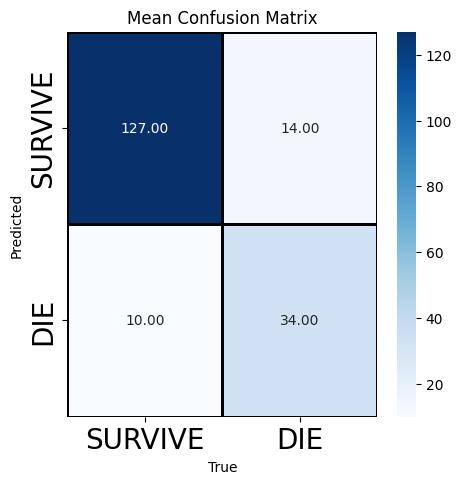

Cross val 

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       192

    accuracy                           1.00       565
   macro avg       1.00      1.00      1.00       565
weighted avg       1.00      1.00      1.00       565

[[373   0]
 [  0 192]]
OCSVM Train finish
0.5483952361063036
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       192

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[545   0]
 [  0 192]]
Testing
Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       

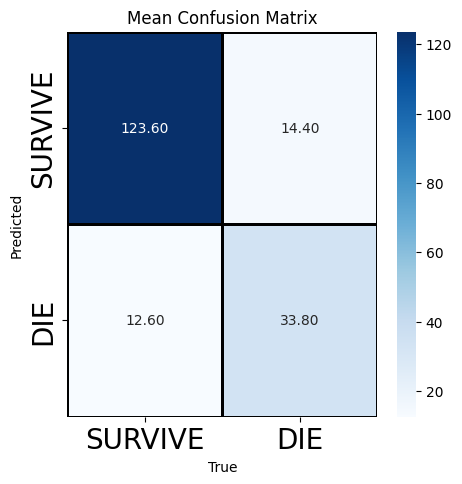

Class SURVIVE - Precision: 0.90, Recall: 0.91, F1 Score: 0.90, Support: 136.2
Class DEATH   - Precision: 0.73, Recall: 0.70, F1 Score: 0.71, Support: 48.199999999999996
Overall Accuracy: 0.8536


In [31]:


data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
#data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


print('Cross val \n')

cross_validate_models(X, y,)

With comorbidity

Train single

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567

[[374   0]
 [  0 193]]
OCSVM Train finish
0.5558282937009006
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00       193

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[544   0]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8540540540540541
Confusion Matrix:
 [[126  11]
 [ 16  32]]
Classification Report:
               precision    recall  f1-score   support

           0      

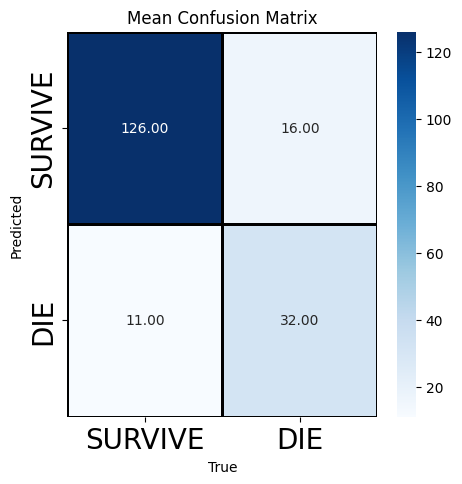

Cross val 

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       192

    accuracy                           1.00       565
   macro avg       1.00      1.00      1.00       565
weighted avg       1.00      1.00      1.00       565

[[373   0]
 [  0 192]]
OCSVM Train finish
0.5363041112747615
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       192

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[545   0]
 [  0 192]]
Testing
Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       

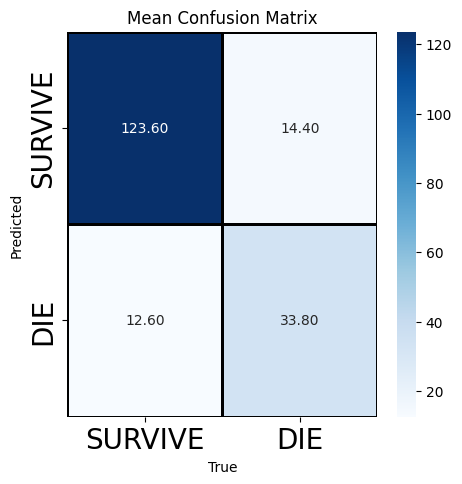

Class SURVIVE - Precision: 0.90, Recall: 0.91, F1 Score: 0.90, Support: 136.2
Class DEATH   - Precision: 0.73, Recall: 0.70, F1 Score: 0.71, Support: 48.199999999999996
Overall Accuracy: 0.8536


In [32]:
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

print('Cross val \n')

cross_validate_models(X, y,)


# Stacked XGBoost with one-class svm Using RFE features

Train single

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567

[[374   0]
 [  0 193]]
OCSVM Train finish
0.6802929593221827
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00       193

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[544   0]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8486486486486486
Confusion Matrix:
 [[124  13]
 [ 15  33]]
Classification Report:
               precision    recall  f1-score   support

           0      

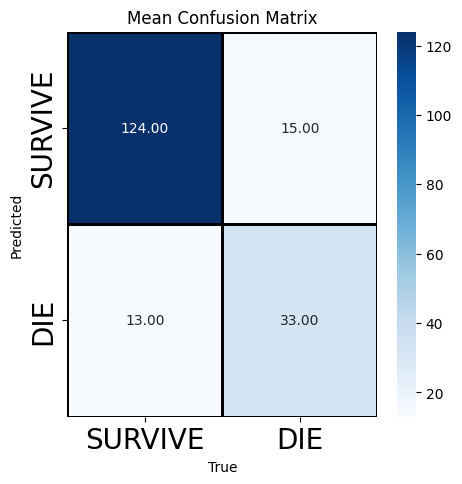

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       192

    accuracy                           1.00       565
   macro avg       1.00      1.00      1.00       565
weighted avg       1.00      1.00      1.00       565

[[373   0]
 [  0 192]]
OCSVM Train finish
0.6673440481630646
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       192

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[545   0]
 [  0 192]]
Testing
Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    acc

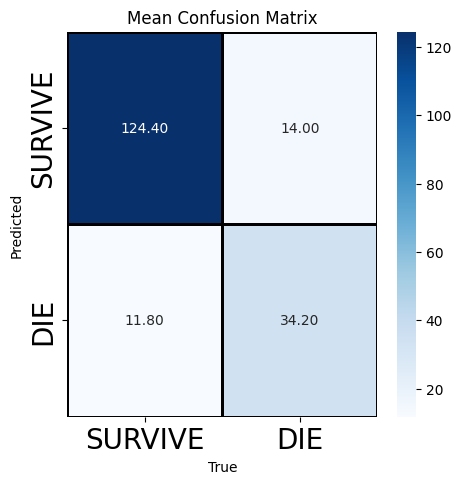

Class SURVIVE - Precision: 0.90, Recall: 0.91, F1 Score: 0.91, Support: 136.20000000000002
Class DEATH   - Precision: 0.74, Recall: 0.71, F1 Score: 0.73, Support: 48.2
Overall Accuracy: 0.8601


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


def train_stackXGB(X_train, y_train):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos
        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T

    
    lin_reg_xgb = LinearRegression()
    lin_reg_xgb.fit(predictions, y_fold)
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    stakxgb_pred = (stakxgb_pred > 0.5).astype(int)
    stakxgb_pred = stakxgb_pred.reshape(-1, 1)
    
    
    print('Stack XGB Train result')
    print(classification_report(y_fold, stakxgb_pred))
    cm = confusion_matrix(y_fold, stakxgb_pred)
    print(cm)
    
    return models, lin_reg_xgb 

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train, features):
    xgb_feature = features['XGB']
    xgbs, lin_reg_xgb = train_stackXGB(X_train[xgb_feature], y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train[xgb_feature])[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    
    svm_feature = features['OCSVM']
    ocsvm = train_one_class_svm(X_train[svm_feature], y_train)
    svm_scores = ocsvm.decision_function(X_train[svm_feature])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features):
    print('Testing')
    xgb_feature = features['XGB']
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test[xgb_feature])[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_feature = features['OCSVM']
    svm_scores = ocsvm.decision_function(X_test[svm_feature])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred

def cross_validate_models(X, y,feature ,n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, feature)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, feature)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")


features = {'OCSVM': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 
           'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_avg', 'bun_min', 'bun_avg', 'car_min', 'car_max', 
           'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 
           'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 
           'hear_mode_Sinus Brady', 'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
           'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy'], 
 'XGB': ['age', 'marital_WIDOWED', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_max', 
         'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 
         'chl_max', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_avg', 'rbc_min', 
         'rbc_max', 'rbc_avg', 'pla_min', 'pla_avg', 'wbc_min', 'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 
         'res_max', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Normal Sinus']}

data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test,features)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

cross_validate_models(X, y, features)



# StackXGB+OCSVM Use logistic regression (not linear reg)

Train single

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567

[[374   0]
 [  0 193]]
OCSVM Train finish
0.5558282937009006
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00       193

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[544   0]
 [  0 193]]
Testing
[ 1.91741773e-03  9.41188466e-04 -2.59050244e-03 -1.85121738e-03
 -1.92017291e-03  1.16302117e-03  2.16357344e-03  8.69343966e-04
  3.66559049e-03  1.97286398e-04  3.97303433e-03  

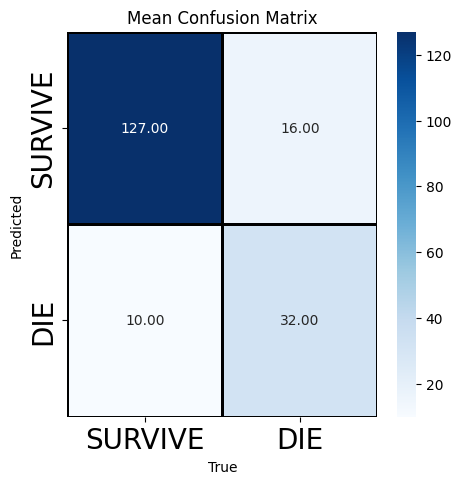

Cross val 

Stack XGB Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       192

    accuracy                           1.00       565
   macro avg       1.00      1.00      1.00       565
weighted avg       1.00      1.00      1.00       565

[[373   0]
 [  0 192]]
OCSVM Train finish
0.5363041112747615
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       192

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[545   0]
 [  0 192]]
Testing
[ 6.24954321e-03  2.04061172e-03 -1.59209397e-03  2.09400060e-03
  3.63934975e-04  2.56275140e-03  3.44589874e-03 -7.05530694e-03
  2.40140596e-03  1.05019450e-03  4.06612146e-04 -5.

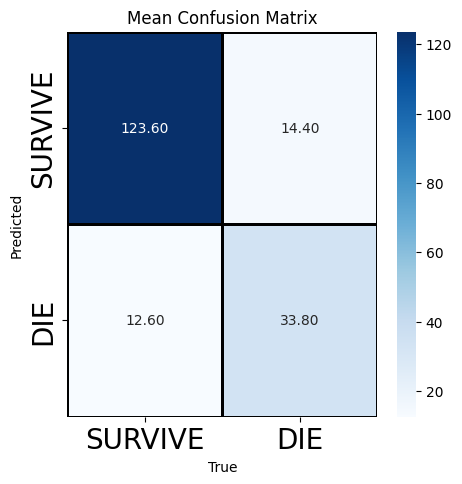

Class SURVIVE - Precision: 0.90, Recall: 0.91, F1 Score: 0.90, Support: 136.2
Class DEATH   - Precision: 0.73, Recall: 0.70, F1 Score: 0.71, Support: 48.199999999999996
Overall Accuracy: 0.8536


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
import seaborn as sns

def train_stackXGB(X_train, y_train):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos

        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T

    
    lin_reg_xgb = LogisticRegression()
    lin_reg_xgb.fit(predictions, y_fold)
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int)
    stakxgb_pred = stakxgb_pred.reshape(-1, 1)
    
    
    print('Stack XGB Train result')
    print(classification_report(y_fold, stakxgb_pred))
    cm = confusion_matrix(y_fold, stakxgb_pred)
    print(cm)
    
    return models, lin_reg_xgb 

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train):
    xgbs, lin_reg_xgb = train_stackXGB(X_train, y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train)[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    

    ocsvm = train_one_class_svm(X_train, y_train)
    svm_scores = ocsvm.decision_function(X_train)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    #ocsvm_pred = normalized_scores.reshape(-1, 1)
    ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_logi_reg = LogisticRegression()
    final_logi_reg.fit(combined_predictions, y_train)
    final_pred = final_logi_reg.predict(combined_predictions)
    #final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_logi_reg


def test_models(models, lin_reg_xgb, ocsvm, final_logi_reg, X_test):
    print('Testing')
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_scores = ocsvm.decision_function(X_test)
    print(svm_scores)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    #ocsvm_pred = normalized_scores
    ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_logi_reg.predict(combined_predictions)
    #final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred
    



def cross_validate_models(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")

data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
# XGB
#X = X[['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 
#       'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 'chl_max', 'chl_avg', 
#       'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_max', 'car_avg', 'rbc_min', 
#       'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_max', 
#       'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 
#       'hear_last_Normal Sinus']]

y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


print('Cross val \n')
cross_validate_models(X, y,)

# Stacking random forest
Using random forest rather than xgboost 

Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       193

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567

[[374   0]
 [  0 193]]
Testing
Accuracy on Test Set: 0.9081081081081082
Confusion Matrix:
 [[130   7]
 [ 10  38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       137
           1       0.84      0.79      0.82        48

    accuracy                           0.91       185
   macro avg       0.89      0.87      0.88       185
weighted avg       0.91      0.91      0.91       185

Train result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       192

    accuracy      

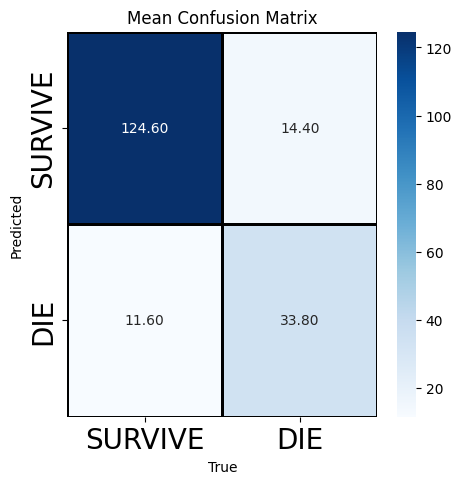

Class SURVIVE - Precision: 0.90, Recall: 0.91, F1 Score: 0.91, Support: 136.2
Class DEATH   - Precision: 0.74, Recall: 0.70, F1 Score: 0.72, Support: 48.199999999999996
Overall Accuracy: 0.8590


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

def train_stackRF(X_train, y_train, thresh = 0.5, norm = False):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])

        model = RandomForestClassifier()
        
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_fold)

    final_pred = lin_reg.predict(predictions)
    final_pred = (final_pred > 0.5).astype(int) 
    
    
    
    ########## normalize scores
    if norm :
        print('niorm')
        stakxgb_scores = lin_reg.predict(predictions)

        mean_val = stakxgb_scores.mean()
        std_val = stakxgb_scores.std()
        standardized_scores = (stakxgb_scores - mean_val) / std_val
        min_val = standardized_scores.min()
        max_val = standardized_scores.max()
        normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

        final_pred = np.where(normalized_scores > thresh, 1,0) 

    print('Train result')
    print(classification_report(y_fold, final_pred))
    cm = confusion_matrix(y_fold, final_pred)
    print(cm)
    
    return models, lin_reg    

def test_models(models, lin_reg, X_test, y_test, thresh = 0.5, norm = False):
    print('Testing')
    test_predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        test_predictions.append(pred)

    test_predictions = np.vstack(test_predictions).T

    final_pred = lin_reg.predict(test_predictions)

    final_pred_class = (final_pred > 0.5).astype(int) 
    
    if norm:
        stakxgb_scores = lin_reg.predict(final_pred)
    
        mean_val = stakxgb_scores.mean()
        std_val = stakxgb_scores.std()
        standardized_scores = (stakxgb_scores - mean_val) / std_val
        min_val = standardized_scores.min()
        max_val = standardized_scores.max()
        normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

        final_pred_class = np.where(normalized_scores > thresh, 1,0)  

    return final_pred_class
    

data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')

columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]

# XGB
#X = X[['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 
#       'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 'chl_max', 'chl_avg', 
#       'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_max', 'car_avg', 'rbc_min', 
#       'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_max', 
#       'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 
#       'hear_last_Normal Sinus']]



# Random Forest
#X = X[['age', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 'figglu_max', 
#       'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 
#       'chl_max', 'chl_avg', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'hemo_max', 'hemo_avg', 
#       'car_min', 'car_max', 'car_avg', 'rbc_min', 'rbc_max', 'rbc_avg', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 
#       'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'mag_max', 'mag_avg', 'res_min', 'res_max', 'res_avg', 'spo_min', 
#       'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Asystole', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)




scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

xgbs, lin_reg = train_stackRF(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg, X_test, y_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))




def cross_validate_models(X, y, norm = False,n_splits=5):
    if norm:
        print('norm')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg = train_stackRF(X_train, y_train, norm)
        
        final_pred_class = test_models(xgbs, lin_reg, X_test, y_test, norm)
        
        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")

cross_validate_models(X, y, norm=True)

# Stack xgb+logi+rf

Train result
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       544
           1       0.95      1.00      0.97       193

    accuracy                           0.99       737
   macro avg       0.97      0.99      0.98       737
weighted avg       0.99      0.99      0.99       737

[[533  11]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8324324324324325
Confusion Matrix:
 [[117  20]
 [ 11  37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       137
           1       0.65      0.77      0.70        48

    accuracy                           0.83       185
   macro avg       0.78      0.81      0.79       185
weighted avg       0.85      0.83      0.84       185

Train result
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       545
           1       0.96      1.00      0.98       192

    accuracy      

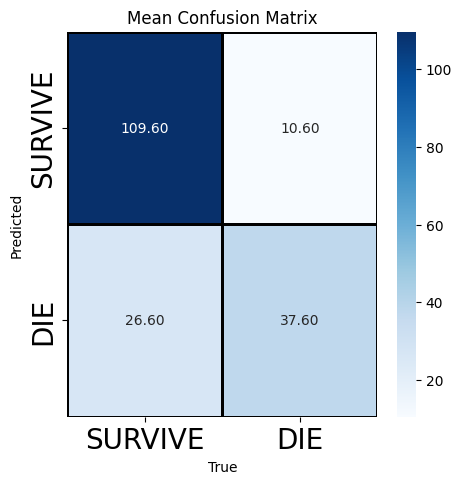

Class SURVIVE - Precision: 0.91, Recall: 0.80, F1 Score: 0.85, Support: 136.2
Class DEATH   - Precision: 0.59, Recall: 0.78, F1 Score: 0.67, Support: 48.2
Overall Accuracy: 0.7983


In [44]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

def train_stackRF(X_train, y_train):
    model_list = [
        ('LogisticRegression', LogisticRegression(max_iter=1000)),
        ('RandomForestClassifier', RandomForestClassifier()),
        ('XGBClassifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',))  # XGBoost 模型预先定义，权重稍后设置
    ]
    
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size = int(X_train_neg.shape[0] / 3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []
    
    for fold_num, (train_idx, _) in enumerate(skf.split(X_train_neg, y_train_neg)):
        model_name, model = model_list[fold_num % len(model_list)]
        
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_fold)
        X_fold = pd.DataFrame(X_train_scaled, columns=X_fold.columns, index=X_fold.index)
        #选feature
        
        
        if model_name == 'XGBClassifier':
            num_neg = np.sum(y_fold == 0)
            num_pos = np.sum(y_fold == 1)
            scale_pos_weight = num_neg / num_pos
            model.set_params(scale_pos_weight=scale_pos_weight)
        
        model.fit(X_fold, y_fold)
        models.append(model)
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        # 选择feature
        
        pred = model.predict_proba(X_train)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_train)  

    final_pred = lin_reg.predict(predictions)
    final_pred = (final_pred > 0.5).astype(int)
    
    print('Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)
    
    return models, lin_reg

def test_models(models, lin_reg, X_test, y_test):
    print('Testing')
    scaler = MinMaxScaler()

    X_test_scale = scaler.fit_transform(X_test)
    X_test = pd.DataFrame(X_test_scale, columns=X_test.columns, index=X_test.index)
    test_predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        test_predictions.append(pred)

    test_predictions = np.vstack(test_predictions).T

    final_pred = lin_reg.predict(test_predictions)

    final_pred_class = (final_pred > 0.5).astype(int) 
    


    return final_pred_class
    

data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')

columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]

# XGB
#X = X[['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 
#       'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 'chl_max', 'chl_avg', 
#       'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_max', 'car_avg', 'rbc_min', 
#       'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_max', 
#       'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 
#       'hear_last_Normal Sinus']]



# Random Forest
#X = X[['age', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 'figglu_max', 
#       'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 
#       'chl_max', 'chl_avg', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'hemo_max', 'hemo_avg', 
#       'car_min', 'car_max', 'car_avg', 'rbc_min', 'rbc_max', 'rbc_avg', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 
#       'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'mag_max', 'mag_avg', 'res_min', 'res_max', 'res_avg', 'spo_min', 
#       'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Asystole', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)



xgbs, lin_reg = train_stackRF(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg, X_test, y_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))




def cross_validate_models(X, y,n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg = train_stackRF(X_train, y_train)
        
        final_pred_class = test_models(xgbs, lin_reg, X_test, y_test)
        
        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")

cross_validate_models(X, y)

# Stack 3 models+ocsvm

Train single

OCSVM Train finish
0.5565414115622537
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       544
           1       0.94      1.00      0.97       193

    accuracy                           0.98       737
   macro avg       0.97      0.99      0.98       737
weighted avg       0.98      0.98      0.98       737

[[532  12]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8540540540540541
Confusion Matrix:
 [[124  13]
 [ 14  34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       137
           1       0.72      0.71      0.72        48

    accuracy                           0.85       185
   macro avg       0.81      0.81      0.81       185
weighted avg       0.85      0.85      0.85       185



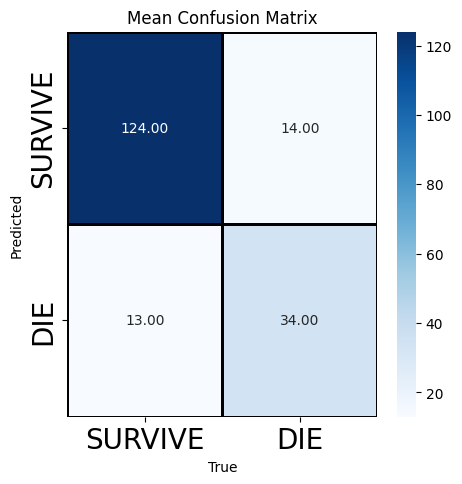

Cross val 

OCSVM Train finish
0.5483952361063036
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       545
           1       0.97      1.00      0.99       192

    accuracy                           0.99       737
   macro avg       0.99      1.00      0.99       737
weighted avg       0.99      0.99      0.99       737

[[540   5]
 [  0 192]]
Testing
OCSVM Train finish
0.5606160703363785
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       544
           1       0.96      1.00      0.98       193

    accuracy                           0.99       737
   macro avg       0.98      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737

[[536   8]
 [  0 193]]
Testing
OCSVM Train finish
0.5689147263863823
(738, 1)
(738, 1)
Final Train result
              precision    recall  f1-score   s

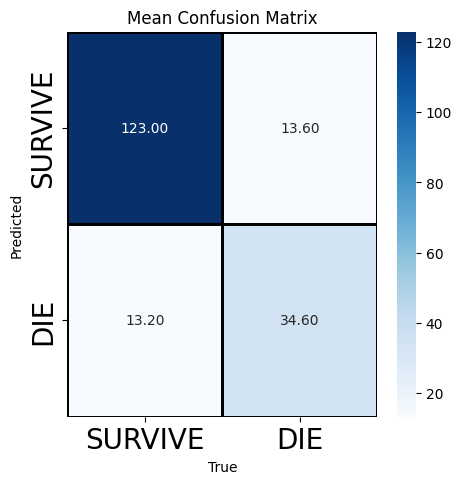

Class SURVIVE - Precision: 0.90, Recall: 0.90, F1 Score: 0.90, Support: 136.2
Class DEATH   - Precision: 0.72, Recall: 0.72, F1 Score: 0.72, Support: 48.2
Overall Accuracy: 0.8547


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
import seaborn as sns

def train_stackXGB(X_train, y_train):
    model_list = [
        ('LogisticRegression', LogisticRegression(max_iter=1000)),
        ('RandomForestClassifier', RandomForestClassifier()),
        ('XGBClassifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',))  # XGBoost 模型预先定义，权重稍后设置
    ]
    
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size = int(X_train_neg.shape[0] / 3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []
    
    for fold_num, (train_idx, _) in enumerate(skf.split(X_train_neg, y_train_neg)):
        model_name, model = model_list[fold_num % len(model_list)]
        
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_fold)
        X_fold = pd.DataFrame(X_train_scaled, columns=X_fold.columns, index=X_fold.index)
        #选feature
        
        
        if model_name == 'XGBClassifier':
            num_neg = np.sum(y_fold == 0)
            num_pos = np.sum(y_fold == 1)
            scale_pos_weight = num_neg / num_pos
            model.set_params(scale_pos_weight=scale_pos_weight)
        
        model.fit(X_fold, y_fold)
        models.append(model)
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        # 选择feature
        
        pred = model.predict_proba(X_train)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_train)  
    
    return models, lin_reg

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train):
    xgbs, lin_reg_xgb = train_stackXGB(X_train, y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train)[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    

    ocsvm = train_one_class_svm(X_train, y_train)
    svm_scores = ocsvm.decision_function(X_train)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test):
    print('Testing')
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_scores = ocsvm.decision_function(X_test)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred
    



def cross_validate_models(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")


data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
#data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


print('Cross val \n')
cross_validate_models(X, y,)

# Stack 3 models + ocsvm + rfe featrures

Train single

OCSVM Train finish
0.6802929593221827
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       544
           1       0.94      1.00      0.97       193

    accuracy                           0.98       737
   macro avg       0.97      0.99      0.98       737
weighted avg       0.98      0.98      0.98       737

[[531  13]
 [  0 193]]
Testing
Accuracy on Test Set: 0.8810810810810811
Confusion Matrix:
 [[126  11]
 [ 11  37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       137
           1       0.77      0.77      0.77        48

    accuracy                           0.88       185
   macro avg       0.85      0.85      0.85       185
weighted avg       0.88      0.88      0.88       185



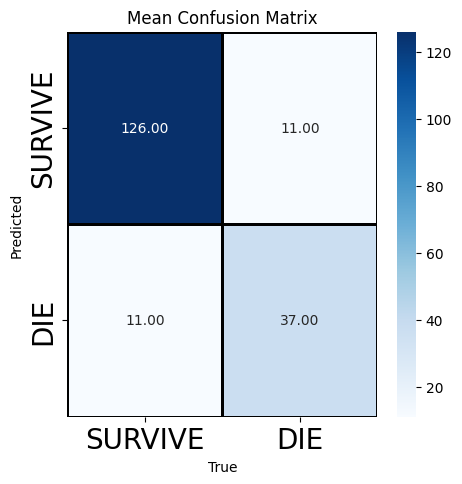

Cross val 

OCSVM Train finish
0.6673440481630646
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       545
           1       0.96      1.00      0.98       192

    accuracy                           0.99       737
   macro avg       0.98      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737

[[537   8]
 [  0 192]]
Testing
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       136
           1       0.87      0.98      0.92        49

    accuracy                           0.96       185
   macro avg       0.93      0.96      0.95       185
weighted avg       0.96      0.96      0.96       185

OCSVM Train finish
0.6386358196102101
(737, 1)
(737, 1)
Final Train result
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       544
           1       0

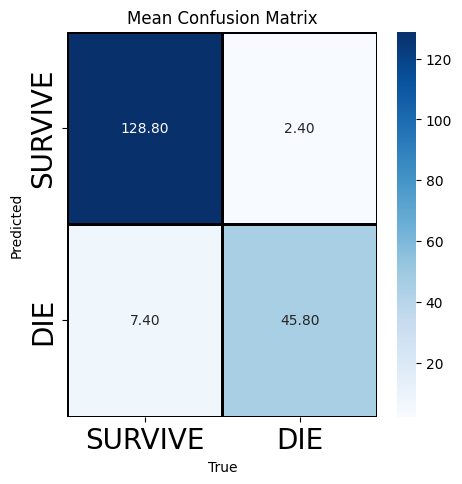

Class SURVIVE - Precision: 0.98, Recall: 0.95, F1 Score: 0.96, Support: 136.20000000000002
Class DEATH   - Precision: 0.86, Recall: 0.95, F1 Score: 0.90, Support: 48.199999999999996
Overall Accuracy: 0.9469


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
import seaborn as sns

def train_stackXGB(X_train, y_train, features):
    model_list = [
        ('Logi', LogisticRegression(max_iter=1000)),
        ('RF', RandomForestClassifier()),
        ('XGB', xgb.XGBClassifier())  # XGBoost 模型预先定义，权重稍后设置
    ]
    
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size = int(X_train_neg.shape[0] / 3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []
    
    for fold_num, (train_idx, _) in enumerate(skf.split(X_train_neg, y_train_neg)):
        model_name, model = model_list[fold_num % len(model_list)]
        feature = features[model_name]
        
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_fold)
        X_fold = pd.DataFrame(X_train_scaled, columns=X_fold.columns, index=X_fold.index)
        #选feature
        
        
        if model_name == 'XGB':
            num_neg = np.sum(y_fold == 0)
            num_pos = np.sum(y_fold == 1)
            scale_pos_weight = num_neg / num_pos
            model.set_params(scale_pos_weight=scale_pos_weight)
        
        model.fit(X_fold[feature], y_fold)
        models.append(model)
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        # 选择feature
        
        pred = model.predict_proba(X_train[feature])[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_train)  
    
    return models, lin_reg

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train, features):
    xgbs, lin_reg_xgb = train_stackXGB(X_train, y_train, features)
    xgb_predictions = []
    models = ['Logi', 'RF', "XGB"]
    for idx, model in enumerate(xgbs):
        feature = features[models[idx]]
        pred = model.predict_proba(X_train[feature])[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    

    ocsvm = train_one_class_svm(X_train[features['OCSVM']], y_train)
    svm_scores = ocsvm.decision_function(X_train[features['OCSVM']])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features):
    print('Testing')
    predictions = []
    models = ['Logi', 'RF', "XGB"]
    for idx, model in enumerate(xgbs):
        feature = features[models[idx]]
        pred = model.predict_proba(X_test[feature])[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_scores = ocsvm.decision_function(X_test[features['OCSVM']])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred
    



def cross_validate_models(X, y, features, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        print("Classification Report:\n", classification_report(y_test, final_pred_class))
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")


#data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']

features = {'OCSVM': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 
           'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_avg', 'bun_min', 'bun_avg', 'car_min', 'car_max', 
           'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 
           'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 
           'hear_mode_Sinus Brady', 'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
           'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy'], 
 'XGB': ['age', 'marital_WIDOWED', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_max', 
         'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 
         'chl_max', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_avg', 'rbc_min', 
         'rbc_max', 'rbc_avg', 'pla_min', 'pla_avg', 'wbc_min', 'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 
         'res_max', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Normal Sinus'],
 'RF': ['age', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 'figglu_max', 
        'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 
        'chl_max', 'chl_avg', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'hemo_max', 'hemo_avg', 
        'car_min', 'car_max', 'car_avg', 'rbc_min', 'rbc_max', 'rbc_avg', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 
        'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'mag_max', 'mag_avg', 'res_min', 'res_max', 'res_avg', 'spo_min', 
        'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Asystole', 'hear_last_Normal Sinus'],
 'Logi': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 
          'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_avg', 'bun_min', 'bun_avg', 'car_min', 'car_max', 
          'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 
          'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 
          'hear_mode_Sinus Brady', 'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
          'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy']}




X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


print('Cross val \n')
cross_validate_models(X, y, features)